In [0]:
# Casey Weiner
# Datascience Final Project

In [0]:
# LOADING THE DATA/PRELIMINARIES

# import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import sklearn as skl
import statsmodels.formula.api as smf
import statsmodels as sm
import datetime as dt
import statsmodels as sm
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
sns.set()


# mount GDrive
from google.colab import drive
drive.mount('gdrive/')

# load data
with open('gdrive/My Drive/bmdslab/final-project/glm.training.data.csv','r') as infile:
  train_set = pd.read_csv(infile)
  train_set = train_set.drop(train_set.columns[0], axis = 1) #Drops first column that just repeats the indices
  
with open('gdrive/My Drive/bmdslab/final-project/glm.test.data.csv','r') as infile:
  test_set = pd.read_csv(infile)
  test_set = test_set.drop(test_set.columns[0], axis = 1)
  
with open('gdrive/My Drive/bmdslab/final-project/test.onsets.csv','r') as infile:
  test_onsets = pd.read_csv(infile)
  test_onsets = test_onsets.drop(test_onsets.columns[0], axis = 1)
  
with open('gdrive/My Drive/bmdslab/final-project/timestamps.test.csv','r') as infile:
  test_timestamps = pd.read_csv(infile)
  test_timestamps = test_timestamps.drop(test_timestamps.columns[0], axis = 1)

Mounted at gdrive/


In [0]:
# FORMATTING DATA

# Finding indices of the first recording of a patient's data
# For the test set, this is denoted test_set_norepeat
test_set_warp = test_set['patient'].drop_duplicates()
indices = test_set_warp.index.values
test_set_norepeat = test_set
test_set_norepeat = test_set_norepeat.take(indices)

# Finding indices of the first recording of a patient's data for the timestamps, then
# concatenating the timestamp data to the formatted dataframe from previous part.

# Eliminating repeats
test_timestamps_norepeat = test_timestamps
test_timestamps_norepeat = test_timestamps_norepeat.take(indices)

# But before concatenating, the year portion of the time stamp needs to be removed
convert = pd.to_datetime(test_timestamps_norepeat['x']).dt.time
convert = pd.DataFrame(convert)
convert_1 = pd.to_datetime(test_timestamps['x']).dt.time
convert_1 = pd.DataFrame(convert)
test_timestamps_norepeat.insert(1, "timestamp", convert, True)
test_timestamps_norepeat = test_timestamps_norepeat.drop(test_timestamps_norepeat.columns[0], axis = 1)

#Concatenation
test_set_norepeat.insert(30, "timestamp", test_timestamps_norepeat, True)
print(test_set_norepeat)

# Making onsets the same format as timestamps
test_onsets_2 = test_onsets
convert2 = pd.to_datetime(test_onsets_2['x']).dt.time
convert2 = pd.DataFrame(convert2)
test_onsets_2.insert(1, "onset", convert2, True)
test_onsets_2 = test_onsets_2.drop(test_onsets_2.columns[0], axis = 1)
print(test_onsets_2)

                 hr         sbp         dbp  ...  patient  y  timestamp
0         71.000000  134.000000  102.000000  ...        1  0   09:00:00
41        87.252031  119.411786   61.039926  ...        2  0   05:14:00
42        87.252031  119.411786   61.039926  ...        3  0   12:00:00
165       87.252031  119.411786   61.039926  ...        4  0   23:52:00
202       50.000000  119.411786   61.039926  ...        5  0   17:09:00
289       87.252031  120.000000   61.000000  ...        6  0   21:00:00
316      114.000000  119.411786   61.039926  ...        7  0   08:05:00
378       87.252031  119.411786   61.039926  ...        8  0   13:00:00
499      106.000000  119.411786   61.039926  ...        9  0   05:47:00
599       87.252031  128.000000   99.000000  ...       10  0   05:16:00
767      114.000000  119.411786   61.039926  ...       11  0   22:39:00
865       87.252031  107.000000   52.000000  ...       12  0   21:33:00
939       87.252031  119.411786   61.039926  ...       13  0   2

1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
Max average AUC is  0.9286133497576105
This is achieved with lambda =  0.001


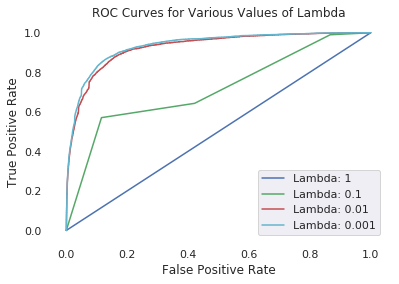

In [0]:
# TASKS B & C

# Data formatting for the training and test sets
test_set_x = test_set.drop('patient', axis = 1)
test_set_x = test_set.drop('y', axis = 1)
train_set_x = train_set.drop('y', axis = 1)
train_set_labels = train_set["y"]

# Preprocessing
train_set_x = pd.DataFrame(preprocessing.scale(train_set_x))
test_set_x = pd.DataFrame(preprocessing.scale(test_set_x))

# Setting up smaller chunks for Stochastic Optimization
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(train_set_x)

# Creating Logistic Regression Model while Testing various Lambda Values

# Lambda test values are given in list
list = [1,0.1,0.01,0.001]
list_str = ['1','0.1','0.01','0.001']

# Nested for-loop for simultaneous classifier building and alpha-value testing
plt.figure()
plt.title("ROC Curves for Various Values of Lambda")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
list_save = []
color_list = ['b','g','r','c']
ind = 0
for i in list:
  list_avg = []
  count = 0
  # Every time, getting different chunks from KFold to generate fit
  for train_index, test_index in kf.split(train_set_x):
    x_train, x_test = train_set_x.iloc[train_index], train_set_x.iloc[test_index]
    y_train, y_test = train_set_labels.iloc[train_index], train_set_labels[test_index]
    fit = lm.SGDClassifier(loss='log',penalty='l1',alpha=i,shuffle=True).fit(x_train, y_train)
    
    # Using generated regression model on test data generated above
    probs = fit.decision_function(x_test)
    count += 1
    print(count)
    
    # Generating points for the ROC by finding different true-positive and 
    # false-positive rates for different thresholds.
    fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
    roc_auc = metrics.auc(fpr, tpr)
    
    #Appending AUC value to list
    list_avg.append(roc_auc)
    
  #Plotting each ROC
  input = list_str[ind]
  name = "Lambda: " + input
  plt.plot(fpr, tpr, color_list[ind], label=name)
  ax = plt.gca()
  ax.set_facecolor('xkcd:white')
  ind += 1
  
  #Appending the average AUC value to other list
  list_save.append(sum(list_avg) / len(list_avg))  

Max_AUC = max(list_save) 

plt.legend(loc='lower right')

print("Max average AUC is ", Max_AUC)
print("This is achieved with lambda = ", list[list_save.index(Max_AUC)])

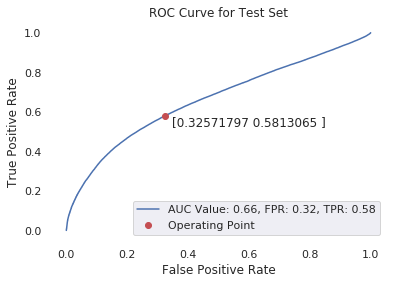

In [0]:
# TASK D

# Plotting the prediction on the test set 
test_set_labels = test_set["y"]
test_set_x = test_set.drop('y', axis = 1)
test_set_x = test_set_x.drop('patient', axis = 1)

test_set_x = pd.DataFrame(preprocessing.scale(test_set_x))

prob = fit.decision_function(test_set_x)
fpr2, tpr2, threshold2 = metrics.roc_curve(test_set_labels, prob)
roc_auc2 = metrics.auc(fpr2, tpr2)
arr = np.array([roc_auc2])
lab = np.array2string(arr)
plt.plot(fpr2, tpr2, label="AUC Value: 0.66, FPR: 0.32, TPR: 0.58")
plt.title("ROC Curve for Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax = plt.gca()
ax.set_facecolor('xkcd:white')

# Finding optimal threshold
import math
iterate = 1
x_val = 0
y_val = 0
for i in range(len(fpr2)):
  new = math.sqrt((fpr2[i])**2 + (tpr2[i] - 1)**2)
  if new < iterate:
    iterate = new
    x_val = fpr2[i]
    y_val = tpr2[i]
    index_E = i

arr2 = np.array([x_val,y_val])
lab2 = np.array2string(arr2)
plt.plot(x_val,y_val,'ro',label="Operating Point")
plt.text(x_val + .02, y_val - .05, lab2)
plt.legend()